In [29]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.environment import EnvSetup
from finrl.env.EnvMultipleStock_train import StockEnvTrain
from finrl.env.EnvMultipleStock_trade import StockEnvTrade
from finrl.model.models import DRLAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot



import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [24]:
df = pd.read_csv('/Users/andriikoval/Documents/uni/WS20-21/IML/ws2020-group-2/data/BTC-USD.csv')
# df2['Date'] = pd.to_datetime(df2.Date, format='%Y-%m-%d')
# df2['Diff'] = np.diff(df2['Close'], prepend=[0])
# df2['Direction'] = np.where(df2['Diff'] >= 0, 'green', 'red')
# df2['Diff_abs'] = np.abs(df2['Diff'])
# df2 = df[df['Date'] > start_date]

# df2.head(10)
df['tic'] = 'BTC'
df = df[['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume', 'tic']]
names = {
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Adj Close': 'close',
    'Volume': 'volume',
    }
df = df.rename(columns=names)
df.head(2)

,date,open,high,low,close,volume,tic
0,2016-12-31,960.627014,963.742981,947.236023,963.742981,99135104,BTC
1,2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008,BTC


In [30]:
## we store the stockstats technical indicator column names in config.py
tech_indicator_list=config.TECHNICAL_INDICATORS_LIST
print(tech_indicator_list)

## user can add more technical indicators
## check https://github.com/jealous/stockstats for different names
tech_indicator_list=tech_indicator_list+['kdjk','open_2_sma','boll','close_10.0_le_5_c','wr_10','dma','trix']
print(tech_indicator_list)

['macd', 'rsi_30', 'cci_30', 'dx_30']
['macd', 'rsi_30', 'cci_30', 'dx_30', 'kdjk', 'open_2_sma', 'boll', 'close_10.0_le_5_c', 'wr_10', 'dma', 'trix']


In [31]:
df = FeatureEngineer(df.copy(),
                    use_technical_indicator=True,
                    tech_indicator_list=tech_indicator_list,
                    user_defined_feature = True,
                    use_turbulence=False).preprocess_data()
df.head(2)

Successfully added technical indicators
Successfully added user defined features


,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,cov_list,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix,daily_return
0,2017-09-09,4229.810059,4308.819824,4114.109863,4226.060059,1386230016,BTC,162.957745,56.785443,-25.740609,12.430506,[[0.001882683819199711]],52.498625,4229.810059,4226.060059,0.0,42.504125,0.0,-0.387797,-0.024401
1,2017-09-10,4229.339844,4245.439941,3951.040039,4122.939941,1679090048,BTC,127.817331,55.187565,-76.151910,19.290976,[[0.001883142301520324]],51.014512,4229.574951,4174.500000,0.0,51.953713,0.0,-0.387797,-0.024401


In [32]:
train = data_split(df, start = '2017-01-01', end = '2019-01-01')
trade = data_split(df, start = '2019-01-01', end = '2020-12-01')

In [33]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

class SingleStockEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = -1, high = 1,shape = (self.action_space,)) 
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (self.state_space,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital amount + close price + shares + technical indicators + other features
        self.state = [self.initial_amount] + \
                      [self.data.close] + \
                      [0]*self.stock_dim  + \
                      sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])+ \
                      [self.data.open] + \
                      [self.data.high] + \
                      [self.data.low] +\
                      [self.data.daily_return] 
        # initialize reward
        self.reward = 0
        self.cost = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self.data.date]
        self.close_price_memory = [self.data.close]
        self.trades = 0
        self._seed()


    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+self.stock_dim+1] > 0:
            #update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+self.stock_dim+1]) * \
             (1- self.transaction_cost_pct)

            self.state[index+self.stock_dim+1] -= min(abs(action), self.state[index+self.stock_dim+1])
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+self.stock_dim+1]) * \
             self.transaction_cost_pct
            self.trades+=1
        else:
            pass

    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        # print('available_amount:{}'.format(available_amount))

        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ self.transaction_cost_pct)

        self.state[index+self.stock_dim+1] += min(available_amount, action)

        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          self.transaction_cost_pct
        self.trades+=1
        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            #plt.plot(self.asset_memory,'r')
            #plt.savefig('results/account_value_train.png')
            #plt.close()
            end_total_asset = self.state[0]+ \
                sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))

            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(end_total_asset))
            df_total_value = pd.DataFrame(self.asset_memory)
            #df_total_value.to_csv('results/account_value_train.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))- self.initial_amount ))
            print("total_cost: ", self.cost)
            print("total_trades: ", self.trades)
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            if df_total_value['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                    df_total_value['daily_return'].std()
              print("Sharpe: ",sharpe)
              print("=================================")
            df_rewards = pd.DataFrame(self.rewards_memory)
            #df_rewards.to_csv('results/account_rewards_train.csv')
            
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print(actions)
            actions = actions * self.hmax
            #print(actions)
            self.actions_memory.append(actions)
            #actions = (actions.astype(int))
            
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    [self.data.close] + \
                    list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]) + \
                      sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])+ \
                      [self.data.open] + \
                      [self.data.high] + \
                      [self.data.low] +\
                      [self.data.daily_return] 
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self.data.date)
            self.close_price_memory.append(self.data.close)

            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset            
            # print("step_reward:{}".format(self.reward))
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward*self.reward_scaling



        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self.data.date]
        #initiate state
        self.state = [self.initial_amount] + \
                      [self.data.close] + \
                      [0]*self.stock_dim + \
                      sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])+ \
                      [self.data.open] + \
                      [self.data.high] + \
                      [self.data.low] +\
                      [self.data.daily_return] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
    
    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'account_value':asset_list})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory[:-1]
        close_price_list = self.close_price_memory[:-1]

        action_list = self.actions_memory
        df_actions = pd.DataFrame({'date':date_list,'actions':action_list,'close_price':close_price_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [35]:
tech_indicator_list

['macd',
 'rsi_30',
 'cci_30',
 'dx_30',
 'kdjk',
 'open_2_sma',
 'boll',
 'close_10.0_le_5_c',
 'wr_10',
 'dma',
 'trix']

In [36]:
len(train.tic.unique())

1

In [38]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_indicator_list)*stock_dimension + 4*stock_dimension
print(state_space)

18


In [41]:
env_setup = EnvSetup(stock_dim = stock_dimension,
                     state_space = state_space,
                     hmax = 200,
                     initial_amount = 100000,
                     transaction_cost_pct = 0.001,
                     tech_indicator_list = tech_indicator_list)
env_train = env_setup.create_env_training(data = train,
                                          env_class = SingleStockEnv)

In [43]:
train.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,cov_list,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix,daily_return
0,2017-09-09,4229.810059,4308.819824,4114.109863,4226.060059,1386230016,BTC,162.957745,56.785443,-25.740609,12.430506,[[0.001882683819199711]],52.498625,4229.810059,4226.060059,0.0,42.504125,0.0,-0.387797,-0.024401
1,2017-09-10,4229.339844,4245.439941,3951.040039,4122.939941,1679090048,BTC,127.817331,55.187565,-76.151910,19.290976,[[0.001883142301520324]],51.014512,4229.574951,4174.500000,0.0,51.953713,0.0,-0.387797,-0.024401
2,2017-09-11,4122.470215,4261.669922,4099.399902,4161.270020,1557330048,BTC,101.886731,55.667244,-59.041352,18.304897,[[0.0018820322953156273]],53.596209,4175.905029,4170.090007,0.0,41.240397,0.0,-0.233829,0.009297
3,2017-09-12,4168.879883,4344.649902,4085.219971,4130.810059,1864530048,BTC,77.979776,55.181665,-57.196758,13.191189,[[0.0018818737173962594]],50.954850,4145.675049,4160.270020,0.0,54.327867,0.0,-0.184539,-0.007320
4,2017-09-13,4131.979980,4131.979980,3789.919922,3882.590088,2219409920,BTC,38.559575,51.401858,-148.943621,25.449669,[[0.0018593484319148058]],39.538385,4150.429932,4104.734033,0.0,83.294545,0.0,-0.274442,-0.060090


In [44]:
agent = DRLAgent(env = env_train)

In [46]:
config.A2C_PARAMS

{'n_steps': 5,
 'ent_coef': 0.01,
 'learning_rate': 0.0007,
 'verbose': 0,
 'timesteps': 20000}

In [47]:
agent = DRLAgent(env = env_train)
env_train = env_setup.create_env_training(data = train,
                                          env_class = SingleStockEnv)
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
a2c_params_tuning = {'n_steps':5, 
			  'ent_coef':0.005, 
			  'learning_rate':0.0007,
			  'verbose':0,
			  'timesteps':100000}
model_a2c = agent.train_A2C(model_name = "A2C_{}".format(now), model_params = a2c_params_tuning)

==============Model Training===========
begin_total_asset:100000
end_total_asset:103958.93931258736
total_reward:3958.939312587361
total_cost:  11839.373110072132
total_trades:  362
Sharpe:  0.3082939247842998
begin_total_asset:100000
end_total_asset:126828.1614156153
total_reward:26828.161415615294
total_cost:  12977.904106812726
total_trades:  360
Sharpe:  0.502400650292111
begin_total_asset:100000
end_total_asset:83325.6180445186
total_reward:-16674.381955481396
total_cost:  13326.929585393847
total_trades:  393
Sharpe:  0.11924214022845193
begin_total_asset:100000
end_total_asset:77777.25240044392
total_reward:-22222.74759955608
total_cost:  8797.619868374797
total_trades:  432
Sharpe:  0.12392636944233784
begin_total_asset:100000
end_total_asset:86325.96033136436
total_reward:-13674.03966863564
total_cost:  11291.08653989065
total_trades:  450
Sharpe:  0.21131782987164174
begin_total_asset:100000
end_total_asset:74513.71958498063
total_reward:-25486.28041501937
total_cost:  6315.5

In [48]:
config.DDPG_PARAMS

{'batch_size': 128,
 'buffer_size': 50000,
 'learning_rate': 0.001,
 'verbose': 0,
 'timesteps': 20000}

In [49]:
agent = DRLAgent(env = env_train)
env_train = env_setup.create_env_training(data = train,
                                          env_class = SingleStockEnv)
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
ddpg_params_tuning = {
                     'batch_size': 128,
			               'buffer_size':100000, 
                     'learning_rate':0.0003,
			               'verbose':0,
			               'timesteps':30000}
model_ddpg = agent.train_DDPG(model_name = "DDPG_{}".format(now), model_params = ddpg_params_tuning)

==============Model Training===========
begin_total_asset:100000
end_total_asset:169266.87777417013
total_reward:69266.87777417013
total_cost:  2507.7134707031246
total_trades:  75
Sharpe:  0.9674629586995006
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0

In [50]:
config.PPO_PARAMS

{'n_steps': 2048,
 'ent_coef': 0.01,
 'learning_rate': 0.00025,
 'batch_size': 64,
 'verbose': 0,
 'timesteps': 20000}

In [51]:
agent = DRLAgent(env = env_train)
env_train = env_setup.create_env_training(data = train,
                                          env_class = SingleStockEnv)

print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
ppo_params_tuning = {'n_steps':128, 
                     'batch_size': 64,
			               'ent_coef':0.005, 
			               'learning_rate':0.00025,
			              'verbose':0,
			              'timesteps':50000}
model_ppo = agent.train_PPO(model_name = "PPO_{}".format(now), model_params = ppo_params_tuning)

==============Model Training===========
begin_total_asset:100000
end_total_asset:46560.5590581523
total_reward:-53439.4409418477
total_cost:  9270.208145956947
total_trades:  370
Sharpe:  -0.4729463695946683
begin_total_asset:100000
end_total_asset:123266.5557689625
total_reward:23266.5557689625
total_cost:  18008.472623694262
total_trades:  383
Sharpe:  0.4717662747116914
begin_total_asset:100000
end_total_asset:104567.37845549616
total_reward:4567.37845549616
total_cost:  22613.241330905304
total_trades:  402
Sharpe:  0.3308949387059847
begin_total_asset:100000
end_total_asset:98409.7530689805
total_reward:-1590.246931019501
total_cost:  29091.725679583957
total_trades:  374
Sharpe:  0.2393982889241417
begin_total_asset:100000
end_total_asset:74238.27407486337
total_reward:-25761.725925136634
total_cost:  14293.05042420118
total_trades:  377
Sharpe:  -0.02455498602342966
begin_total_asset:100000
end_total_asset:223307.49023610778
total_reward:123307.49023610778
total_cost:  30129.006

In [52]:
config.TD3_PARAMS

{'batch_size': 100,
 'buffer_size': 1000000,
 'learning_rate': 0.001,
 'verbose': 0,
 'timesteps': 30000}

In [53]:
agent = DRLAgent(env = env_train)
env_train = env_setup.create_env_training(data = train,
                                          env_class = SingleStockEnv)

print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
td3_params_tuning = {
                     'batch_size': 100,
			               'buffer_size':1000000, 
                     'learning_rate': 0.001,
			               'verbose':0,
			               'timesteps':30000}
model_td3 = agent.train_TD3(model_name = "TD3_{}".format(now), model_params = td3_params_tuning)

==============Model Training===========
begin_total_asset:100000
end_total_asset:107478.44057700885
total_reward:7478.440577008849
total_cost:  2568.275999847114
total_trades:  80
Sharpe:  0.26951923346224993
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0

In [54]:
config.SAC_PARAMS

{'batch_size': 64,
 'buffer_size': 100000,
 'learning_rate': 0.0001,
 'learning_starts': 100,
 'ent_coef': 'auto_0.1',
 'timesteps': 50000,
 'verbose': 0}

In [55]:
agent = DRLAgent(env = env_train)
env_train = env_setup.create_env_training(data = train,
                                          env_class = SingleStockEnv)

print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
sac_params_tuning={
  'batch_size': 64,
 'buffer_size': 100000,
  'ent_coef':'auto_0.1',
 'learning_rate': 0.0001,
 'learning_starts':200,
 'timesteps': 30000,
 'verbose': 0}
model_sac = agent.train_SAC(model_name = "SAC_{}".format(now), model_params = sac_params_tuning)

==============Model Training===========
begin_total_asset:100000
end_total_asset:102094.19695447359
total_reward:2094.196954473591
total_cost:  7542.430969735747
total_trades:  157
Sharpe:  0.25145160278954665
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  0
begin_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total_trades:  

In [60]:
trade.tail()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,cov_list,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix,daily_return
695,2020-11-26,18729.839844,18866.285156,16351.035156,17150.623047,61396835736,BTC,1179.257204,62.720486,64.465630,6.639183,[[0.0008731604460818149]],64.851566,18917.125000,17011.312500,0.0,73.697158,3809.801953,1.264570,-0.084427
696,2020-11-27,17153.914062,17445.023438,16526.423828,17108.402344,38886494645,BTC,1040.245904,62.448354,41.963883,6.639183,[[0.0008733100654608582]],51.539034,17941.876953,17125.044922,0.0,75.086029,3632.406074,1.176737,-0.002462
697,2020-11-28,17112.933594,17853.939453,16910.652344,17717.414062,32601040733,BTC,968.061394,64.731730,57.903023,12.425424,[[0.0008769705734143345]],49.341928,17133.423828,17236.937256,0.0,55.052286,3490.987930,1.085936,0.035597
698,2020-11-29,17719.634766,18283.628906,17559.117188,18177.484375,31133957704,BTC,937.175306,66.331629,75.585527,18.125306,[[0.0008633703550657422]],52.921937,17416.284180,17379.195703,0.0,39.918044,3389.404922,1.005775,0.025967
699,2020-11-30,18178.322266,19749.263672,18178.322266,19625.835938,47728480399,BTC,1017.834759,70.665360,120.640728,33.828663,[[0.000849222140562154]],67.403918,17948.978516,17595.942383,0.0,3.632120,3325.023984,0.965683,0.079678


In [145]:
for i in range(1, 10):
    trade = trade.append({'date': f'2020-12-2{i}'}, ignore_index=True)
trade.tail()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,cov_list,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix,daily_return
359,2020-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
360,2020-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361,2020-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362,2020-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
363,2020-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
trade = data_split(df, start = '2020-01-01', end = '2020-12-31')

env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                                    env_class = SingleStockEnv)

In [146]:
trade.tail(20)

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,cov_list,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix,daily_return
344,2020-12-10,18553.298828,18553.298828,17957.064453,18264.992188,2.554713e+10,BTC,636.672710,59.064395,21.067018,11.260657,[[0.0008160457456839679]],37.714212,18437.091797,18598.799512,0.0,82.755416,2474.912285,0.594906,-0.015572
345,2020-12-11,18263.929688,18268.453125,17619.533203,18058.904297,2.791964e+10,BTC,543.682982,58.011305,-4.345649,4.354617,[[0.0008163231220232307]],32.666318,18408.614258,18569.633105,0.0,77.429469,2298.642656,0.521791,-0.011283
346,2020-12-12,18051.320312,18919.550781,18046.041016,18803.656250,2.175258e+10,BTC,524.042376,60.635108,39.475480,15.207403,[[0.0008207758545786539]],42.640895,18157.625000,18591.315820,0.0,39.171497,2141.456758,0.462487,0.041240
347,2020-12-13,18806.765625,19381.535156,18734.332031,19142.382812,2.545047e+10,BTC,529.703367,61.759414,79.011194,21.926712,[[0.0008205382128328773]],56.749418,18429.042969,18630.228906,0.0,19.505636,1990.468789,0.420419,0.018014
348,2020-12-14,19144.492188,19305.099609,19012.708984,19246.644531,2.247400e+10,BTC,536.419285,62.104055,86.492286,21.926712,[[0.0008029875946223448]],68.094173,18975.628906,18637.187891,0.0,9.216318,1920.847266,0.391891,0.005447
349,2020-12-15,19246.919922,19525.007812,19079.841797,19417.076172,2.674198e+10,BTC,549.163690,62.672927,99.798316,25.152853,[[0.0008018602027239371]],76.841351,19195.706055,18671.435645,0.0,5.664292,1820.295273,0.375247,0.008855
350,2020-12-16,19418.818359,21458.908203,19298.316406,21310.597656,4.440901e+10,BTC,703.940494,68.165366,236.426810,46.093096,[[0.0008351133692637788]],83.273273,19332.869141,18879.434375,0.0,3.862883,1863.715352,0.403250,0.097518
351,2020-12-17,21308.351562,23642.660156,21234.675781,22805.162109,7.137861e+10,BTC,936.406773,71.579922,375.529596,59.701993,[[0.0008517831343165282]],84.213947,20363.584961,19164.272363,0.0,13.904705,2034.390938,0.484207,0.070132
352,2020-12-18,22806.796875,23238.601562,22399.812500,23137.960938,4.038790e+10,BTC,1134.415225,72.265174,342.660011,59.701993,[[0.0008353679372213122]],86.682846,22057.574219,19435.299707,0.0,8.379355,2322.071016,0.595792,0.014593
353,2020-12-19,23132.865234,24085.855469,22826.472656,23869.832031,3.848755e+10,BTC,1335.005123,73.707404,318.819459,63.758249,[[0.0008379729330571286]],90.008315,22969.831055,19719.917090,0.0,3.340747,2647.196426,0.729681,0.031631


In [147]:
df_account_value, df_actions = DRLAgent.DRL_prediction(model=model_ppo,
                                           test_data = trade,
                                           test_env = env_trade,
                                           test_obs = obs_trade)

begin_total_asset:100000
end_total_asset:96957.18618602742
total_reward:-3042.813813972578
total_cost:  326.51467806079796
total_trades:  10
Sharpe:  -0.37884269903395656


ValueError: arrays must all be same length

In [148]:
df_actions.tail()

,date,actions,close_price
4,2020-01-05,[-200.0],7411.317383
5,2020-01-06,[-200.0],7769.219238
6,2020-01-07,[-200.0],8163.692383
7,2020-01-08,[-200.0],8079.862793
8,2020-01-09,[-200.0],7879.071289


In [149]:
df_account_value.tail()

,date,account_value
5,2020-01-06,100000.0
6,2020-01-07,100000.0
7,2020-01-08,100000.0
8,2020-01-09,100000.0
9,2020-01-10,100000.0


In [150]:
print("==============Get Backtest Results===========")
perf_stats_all = BackTestStats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========


ZeroDivisionError: float division by zero

In [101]:
print("==============Compare to BTC-USD itself buy-and-hold===========")
%matplotlib inline
BackTestPlot(account_value=df_account_value, baseline_ticker = 'BTC-USD')

==============Compare to BTC-USD itself buy-and-hold===========
annual return:  1.1068715633765658
sharpe ratio:  0.17751055420705986
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (701, 7)


Start date,2019-01-01
End date,2019-12-20
Total months,16
,Backtest
Annual return,0.913%
Cumulative returns,1.286%
Annual volatility,6.201%
Sharpe ratio,0.18
Calmar ratio,0.15
Stability,0.11
Max drawdown,-6.211%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.21,2019-05-28,2019-09-24,NaT,NaN
1,0.78,2019-05-25,2019-05-26,2019-05-27,1
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2019-12-20 00:00:00+0000', tz='UTC'))

In [102]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=BaselineStats('BTC-USD')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (701, 7)
Annual return          0.814270
Cumulative returns     4.243763
Annual volatility      0.583545
Sharpe ratio           1.326104
Calmar ratio           1.317358
Stability              0.530271
Max drawdown          -0.618109
Omega ratio            1.310194
Sortino ratio          1.952957
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.211954
Daily value at risk   -0.070449
Alpha                  0.000000
Beta                   1.000000
dtype: float64


In [103]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=BaselineStats('^GSPC')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (484, 7)
Annual return          0.211125
Cumulative returns     0.444693
Annual volatility      0.264110
Sharpe ratio           0.859995
Calmar ratio           0.622330
Stability              0.470226
Max drawdown          -0.339250
Omega ratio            1.201516
Sortino ratio          1.185297
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.726828
Daily value at risk   -0.032373
Alpha                  0.000000
Beta                   1.000000
dtype: float64


==============Compare to S&P 500===========
annual return:  1.1068715633765658
sharpe ratio:  0.17751055420705986
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (484, 7)


Start date,2019-01-02
End date,2020-05-28
Total months,16
,Backtest
Annual return,0.913%
Cumulative returns,1.286%
Annual volatility,6.201%
Sharpe ratio,0.18
Calmar ratio,0.15
Stability,0.11
Max drawdown,-6.211%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.21,2019-08-02,2020-01-23,NaT,NaN
1,0.78,2019-07-30,2019-07-31,2019-08-01,3
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


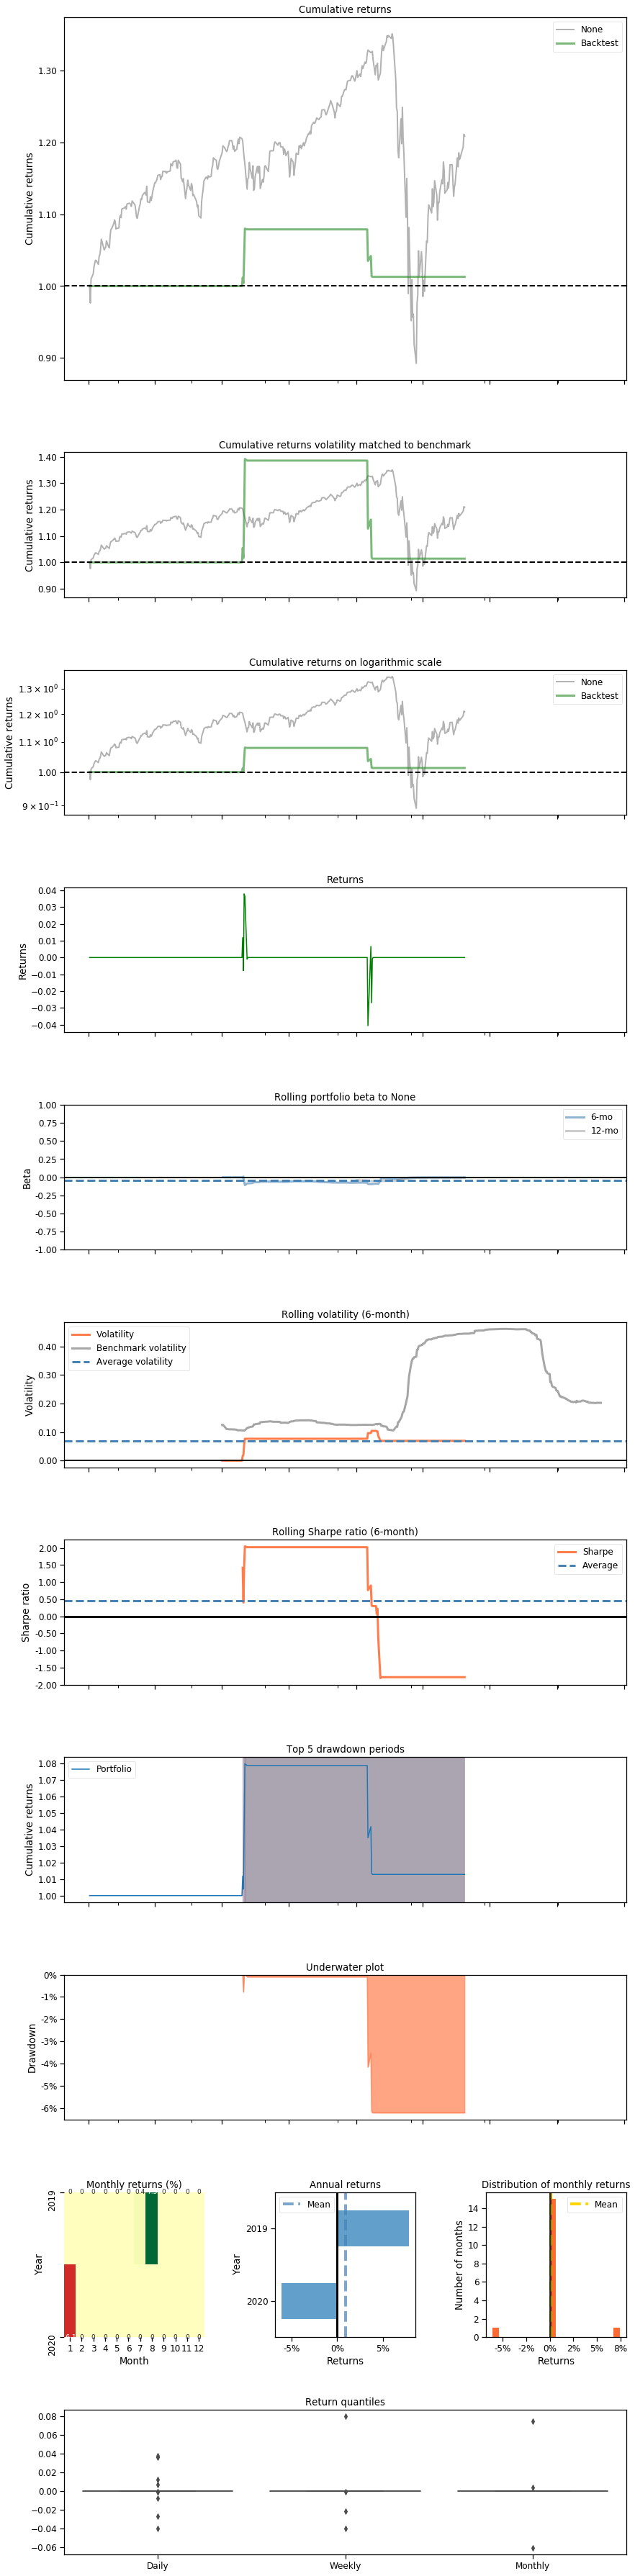

In [104]:
print("==============Compare to S&P 500===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
BackTestPlot(df_account_value, baseline_ticker = '^GSPC')

In [152]:
obs_trade

array([[ 1.0000000e+05,  7.2001743e+03,  0.0000000e+00, -6.1114300e+01,
         4.3940060e+01, -3.7921432e+01,  1.0831907e+00,  2.3783457e+01,
         7.2446655e+03,  7.2215327e+03,  0.0000000e+00,  9.3750702e+01,
        -2.0421275e+02, -6.3528880e-02,  7.1948921e+03,  7.2543306e+03,
         7.1749443e+03,  9.1403414e-04]], dtype=float32)

In [151]:
account_memory = []
actions_memory = []

action, _states = model_ppo.predict(obs_trade)

# df_account_value, df_actions = DRLAgent.DRL_prediction(model=model_ppo,
#                                            test_data = trade,
#                                            test_env = env_trade,
#                                            test_obs = obs_trade)

def get_prediction(model=model_ppo,
                    test_env=env_trade,
                    test_data=trade,
                    test_obs=obs_trade):
    """make a prediction"""
    # start = time.time()
    account_memory = []
    actions_memory = []
    # for i in range(len(test_data.index.unique())):
    for i in range(31):
        action, _states = model.predict(test_obs)
        test_obs, rewards, dones, info = test_env.step(action)
        if i == (10 - 2):
            account_memory = test_env.env_method(method_name = 'save_asset_memory')
            actions_memory = test_env.env_method(method_name = 'save_action_memory')
    # end = time.time()
    return account_memory[0], actions_memory[0]

df_account_value, df_actions = get_prediction(model=model_ppo,
test_data = trade,
                    test_env=env_trade,
                    test_obs=obs_trade)

ValueError: arrays must all be same length

In [138]:
df_account_value.tail()

,date,account_value
5,2020-01-06,100000.0
6,2020-01-07,100000.0
7,2020-01-08,100000.0
8,2020-01-09,100000.0
9,2020-01-10,100000.0


In [139]:
df_actions.tail()

,date,actions,close_price
4,2020-01-05,[-200.0],7411.317383
5,2020-01-06,[-200.0],7769.219238
6,2020-01-07,[-200.0],8163.692383
7,2020-01-08,[-200.0],8079.862793
8,2020-01-09,[-200.0],7879.071289
